In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import h5py
import pandas as pd
sns.set_color_codes()

# Data generation

In [ ]:
pk_list = []
for loc in (2, 4, 8):
    pk_list.append(np.random.normal(loc, 0.3, 500 * loc))
    
pk_list.append(np.random.uniform(0, 12, 5000))

xs = np.concatenate(pk_list)
del pk_list

In [ ]:
with h5py.File('example_data.h5', 'w') as f:
    f['data'] = xs

# Read data

In [7]:
with h5py.File('example_data.h5', 'r') as f:
    raw_data = f['data'][:]

Create a histogram. Put into a DataFrame.

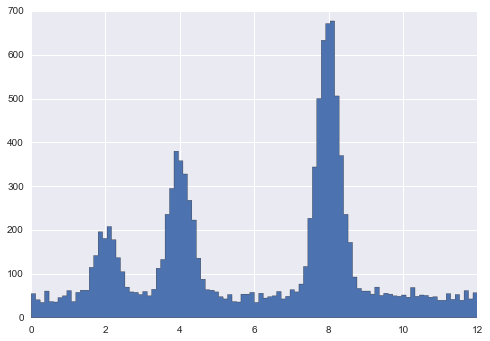

In [8]:
counts, bins, fig = plt.hist(raw_data, bins=100, histtype='stepfilled')
spectrum = pd.DataFrame(counts, columns=('counts',), index=bins[:-1])

In [9]:
spectrum.head()

,counts
0.003417,55
0.123379,41
0.243342,35
0.363305,61
0.483268,37


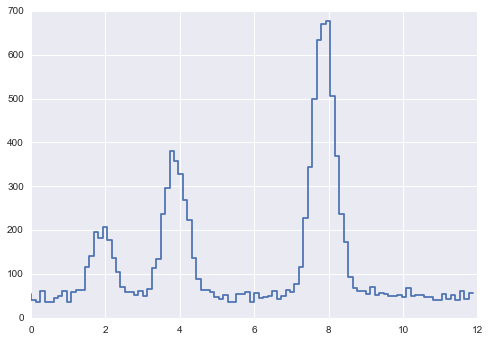

In [10]:
plt.step(spectrum.index, spectrum.counts)

# Baseline subtraction

In [11]:
baseline = spectrum.counts.median()
spectrum['bs_sub'] = spectrum.counts - baseline

In [12]:
spectrum.head()

,counts,bs_sub
0.003417,55,-4
0.123379,41,-18
0.243342,35,-24
0.363305,61,2
0.483268,37,-22


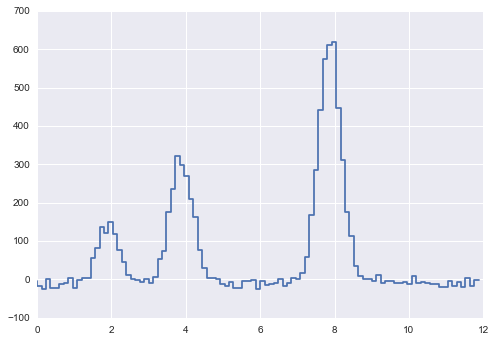

In [13]:
plt.step(spectrum.index, spectrum.bs_sub)

# Apply a threshold

In [14]:
spectrum['clean'] = np.where(spectrum.bs_sub > 15, spectrum.bs_sub, 0)

In [15]:
spectrum.head()

,counts,bs_sub,clean
0.003417,55,-4,0
0.123379,41,-18,0
0.243342,35,-24,0
0.363305,61,2,0
0.483268,37,-22,0


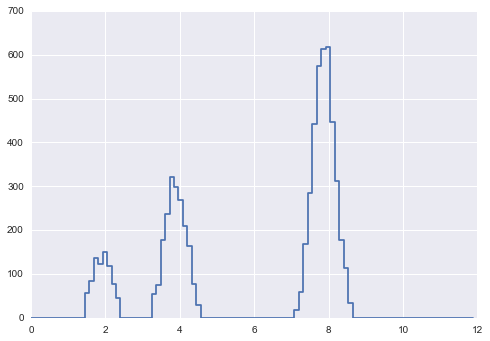

In [16]:
plt.step(spectrum.index, spectrum.clean)

# Find peaks

In [17]:
from scipy.signal import argrelmax

In [18]:
maxlocs = argrelmax(spectrum.clean.values, order=10)[0]
maxima = spectrum.iloc[maxlocs]

In [19]:
maxima

,counts,bs_sub,clean
2.042784,208,149,149
3.842226,380,321,321
8.040924,677,618,618


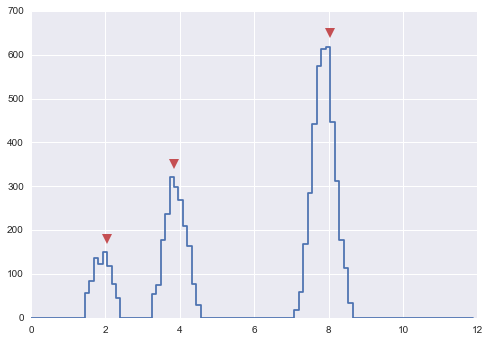

In [20]:
plt.step(spectrum.index, spectrum.clean)
plt.plot(maxima.index, maxima.clean + 0.05 * spectrum.clean.max(), 'rv', markersize=10)

In [21]:
spectrum['peak_num'] = np.nan
for pknum, (en, ct) in enumerate(maxima.iterrows()):
    spectrum.loc[np.abs(spectrum.index - en) < 1, 'peak_num'] = pknum

In [22]:
spectrum.dropna().head()

,counts,bs_sub,clean,peak_num
1.083082,37,-22,0,0
1.203045,58,-1,0,0
1.323007,63,4,0,0
1.442970,63,4,0,0
1.562933,115,56,56,0


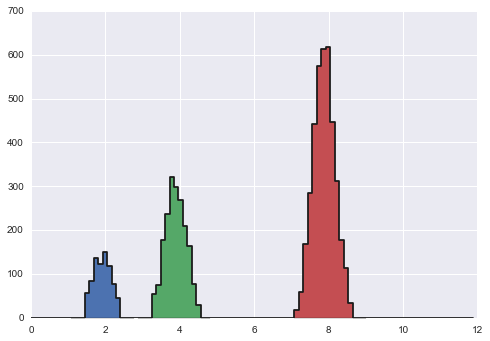

In [23]:
plt.step(spectrum.index, spectrum.clean, 'k')
palette = sns.color_palette()
for pknum in spectrum.peak_num.dropna().unique():
    plt.fill_between(spectrum.index, spectrum.clean, 
                     where=(spectrum.peak_num == pknum), step='pre', 
                     facecolor=palette[int(pknum)])

# Fit peaks with a Gaussian

Normal distribution:
$$f(x) = \frac{A}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

In [24]:
def gaus(x, a, m, s):
    return a / (s * np.sqrt(2*np.pi)) * np.exp(- (x - m)**2 / (2 * s**2))

In [25]:
pknums = spectrum.peak_num.dropna().unique().astype('int')
peaks = pd.DataFrame(columns=('amplitude', 'center', 'sigma'), index=pknums)

for pknum in pknums:
    fitdata = spectrum[spectrum.peak_num == pknum]
    fparams, fcov = curve_fit(gaus, fitdata.index.values, fitdata.clean.values, 
                              p0=(maxima.counts.values[pknum], maxima.index.values[pknum], 0.5))
    peaks.loc[pknum] = fparams

In [26]:
peaks

,amplitude,center,sigma
0,98.4057,1.97262,0.263589
1,233.725,3.94159,0.295589
2,466.172,7.93278,0.294995


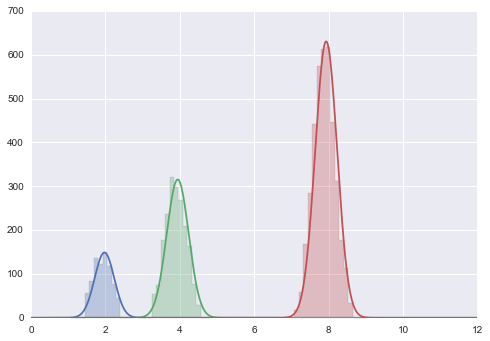

In [27]:
xs = np.linspace(0, 12, 1000)

for pknum in pknums:
    fparams = peaks.iloc[pknum]
    plt.plot(xs, gaus(xs, *fparams))
    plt.fill_between(spectrum.index, spectrum.clean, 
                     where=(spectrum.peak_num == pknum), step='pre', 
                     facecolor=palette[pknum], alpha=0.3)